In [1]:
import numpy as np
from dLdp import analytic_dLdp
from matplotlib import pyplot as plt
from matplotlib import style
from functools import partial

In [2]:
def plot_trajectories(q_traj,p_trajs,n_p):
    style.use('fivethirtyeight')
    p_trajs=p_trajs.reshape(-1,n_p,2)
    plt.plot(q_traj[0,:],q_traj[1,:],'*',label="Target")
    for i in range(n_p):
        plt.plot(p_trajs[:,i,0],p_trajs[:,i,1],'.',label="Mobile Sensor {}".format(i))
    plt.legend()
    plt.show()


In [3]:
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([0.,0.])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])


In [4]:
q_traj=q[...,np.newaxis]
p_trajs=ps[...,np.newaxis]

# Path Planning with constant step size. That is $||\alpha_i \nabla_{p_i}L||=constant$

In [5]:
def polar_projection(q,ps,r):    
    """ 
        Return the projection of a set of points ps onto a circle centered at q with radius r
    """
    q=q.reshape(-1,2)
    ps=ps.reshape(-1,2)
    dists=np.linalg.norm(ps-q,axis=1)

    dists[dists==0]=1 # Handling the zero distances
    ps_proj=((ps-q).T/dists * r).T +q
    return ps_proj

def FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon):
    """
        f_dLdp: a function handle, f_dLdp(q,ps)=dLdp.
        q: Current location of the target.
        ps: Current locations of the mobile sensors.
        n_p: The number of sensors
        n_timesteps: The number of timesteps to plan ahead. The total time horizon T will be T=n_timesteps*dt.
        
        max_linear_speed: the linear speed limit to be set on the mobile sensors.
        dt: the time differences between two consecutive waypoints.
        
        The update step size will be a constant = max_linear_speed * dt
        
        epsilon: when the planned trajectories end, how far away should they be to the target.
    """

    step_size=max_linear_speed*dt
    p_trajs=[]
    
    q=q.reshape(-1,2)
    ps=ps.reshape(-1,2)
    p_trajs.append(ps)
    for i in range(n_timesteps):
        # Calculate the gradient
        grad=f_dLdp(q,ps)
        grad=grad.reshape(-1,2)
        grad_sizes=np.linalg.norm(grad,axis=1)

        grad_sizes[grad_sizes==0]=1 # Handle the case where the partial derivative is zero.

        update_steps=(grad.T/grad_sizes * step_size).T # Calculate the update steps to be applied to ps

        candid_ps=ps+update_steps # Calculate the direct update before projecting onto the target sphere.

        # Project candid_ps onto the "surveillance circle" once it steps into it
        if not np.all(np.linalg.norm(candid_ps-q,axis=1)>=epsilon):
            insiders=np.linalg.norm(candid_ps-q,axis=1)<epsilon
            ps=candid_ps
            ps[insiders]=polar_projection(q,candid_ps,epsilon)[insiders] # Update ps.
            p_trajs.append(ps)
            break # Exit the loop
        else:
            ps=candid_ps # Update ps.
            p_trajs.append(ps)
    return np.array(p_trajs).reshape(-1,n_p,2) # Shape= (num_time_steps,num_sensors,2)

# A typical working example

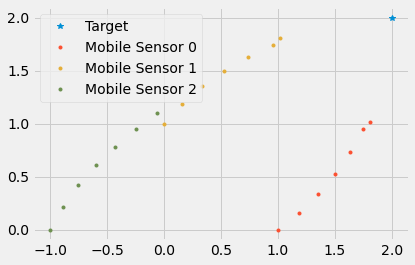

In [6]:
max_linear_speed=1.22
dt=0.2
epsilon=1
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([2,2])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])

n_p=3
n_timesteps=100

f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,3)

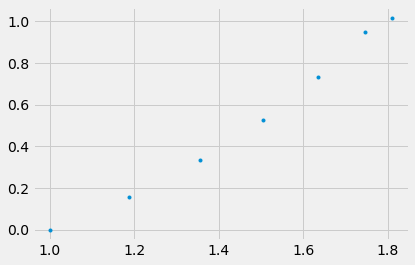

In [7]:
plt.plot(p_trajs[:,0,0],p_trajs[:,0,1],'.')

In [140]:

def fit_spatial_polynomial(waypoints,poly_order, state_space_dim):
    """
        Fit a spatial polynomial p(s)-> R^state_space_dim, s in 0~1, to fit the waypoints.
    """
    if waypoints.shape[1]!=state_space_dim:
        waypoints=waypoints.T
    
    assert(waypoints.shape[1]==state_space_dim)
    
    n = waypoints.shape[0]

    s = np.array([i/(n-1) for i in range(n)])
    S = np.vstack([np.power(s,k) for k in range(poly_order+1)])
    S = S.T
    
    # The two formulas below are equivalent if S is full rank.
#     poly_coefs= np.linalg.inv(S.dot(S.T))).dot(waypoints)
    poly_coefs = np.linalg.pinv(S).dot(waypoints)
    return poly_coefs,S

def polynomial(poly_coefs,x):
    '''
        Evaluate the value of the polynomial specified by poly_coefs at locations x.
    '''
    S = np.vstack([np.power(x,k) for k in range(len(poly_coefs))])
    y = np.array(poly_coefs).dot(S)
    return y
def diff_poly_coefs(poly_coefs):
    '''
        Calculate the coefs of the polynomial after taking the first-order derivative.
    '''
    if len(poly_coefs)==1:
        coefs = [0]
    else:
        coefs = np.array(range(len(poly_coefs)))*poly_coefs
        coefs = coefs[1:]
    return coefs

def generate_2D_spline_motion(waypoints,poly_order, state_space_dim):
    coef,S = fit_spatial_polynomial(waypoints,poly_order, state_space_dim)
    
    # coef.shape = (poly_order+1,state_space_dim)
    # S.shape = (n_waypoints,poly_order+1), 
    # S = [[1,s_i,s_i^2,s_i^3,...,s_i^poly_order]]_{i=0...n_waypoints}, s_i = i/n_waypoints
    
    dotCoef = np.vstack([diff_poly_coefs(coef[:,i]) for i in range(state_space_dim)]).T
    # dotCoef.shape = (poly_order,state_space_dim)
    
    ddotCoef = np.vstack([diff_poly_coefs(dotCoef[:,i]) for i in range(state_space_dim)]).T
    # ddotCoef.shape = (poly_order-1,state_space_dim)
    
    p = S[:,:poly_order+1].dot(coef)
    # p.shape = (n_waypoints,state_space_dim)
    
    pDot = S[:,:poly_order].dot(dotCoef)
    # pDot.shape = (n_waypoints,state_space_dim)
    
    pDDot = S[:,:poly_order-1].dot(ddotCoef)
    # pDot.shape = (n_waypoints,state_space_dim)
    
    theta = np.arctan2(pDot[:,1],pDot[:,0])
    # The facing angles at each p, shape=(n_waypoints,)
    
    v= np.linalg.norm(pDot,axis=1)
    # The velocity, derivative in s. shape = (n_waypoints,)
    
    omega = (pDDot[:,1]*pDot[:,0]-pDDot[:,0]*pDot[:,1])/np.power(v,2)
    # The angular velocity, rotating counter-clockwise as positive. shape=(n_waypoints,)
    return p,pDot,pDDot,theta,v,omega

In [141]:
poly_order=3
state_space_dim=2
p,pDot,pDDot,theta,v,omega=generate_2D_spline_motion(waypoints,poly_order, state_space_dim)

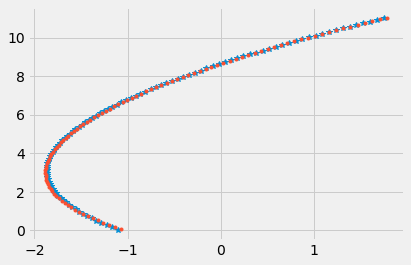

In [129]:
plt.plot(p[:,0],p[:,1],'*')
plt.plot(waypoints[:,0],waypoints[:,1],'.')


In [144]:
v/omega

array([ -6.72128786,  -6.6422966 ,  -6.57151933,  -6.50877885,
        -6.45390753,  -6.40674705,  -6.36714818,  -6.33497048,
        -6.31008206,  -6.29235927,  -6.28168638,  -6.27795526,
        -6.28106503,  -6.2909217 ,  -6.30743781,  -6.33053205,
        -6.36012886,  -6.39615805,  -6.43855438,  -6.48725717,
        -6.54220987,  -6.60335965,  -6.67065702,  -6.74405537,
        -6.82351056,  -6.90898058,  -7.00042505,  -7.09780488,
        -7.20108188,  -7.31021833,  -7.42517664,  -7.54591898,
        -7.67240687,  -7.80460089,  -7.94246028,  -8.08594264,
        -8.23500357,  -8.38959639,  -8.54967181,  -8.71517761,
        -8.88605842,  -9.06225534,  -9.24370575,  -9.43034301,
        -9.62209622,  -9.81888996, -10.02064403, -10.22727328,
       -10.43868731, -10.65479031, -10.87548081, -11.10065149,
       -11.33018895, -11.56397357, -11.80187925, -12.04377326,
       -12.28951604, -12.53896104, -12.79195451, -13.04833532,
       -13.30793481, -13.57057663, -13.8360765 , -14.10

In [143]:
omega/np.pi * 180

array([-111.39586995, -111.83085206, -112.18195897, -112.44759528,
       -112.62655042, -112.71801266, -112.72157859, -112.63725785,
       -112.46547308, -112.20705498, -111.8632327 , -111.43561962,
       -110.92619504, -110.33728197, -109.6715215 , -108.93184447,
       -108.12144067, -107.24372641, -106.30231094, -105.30096232,
       -104.2435732 , -103.13412717, -101.9766661 , -100.77525878,
        -99.53397135,  -98.2568398 ,  -96.94784463,  -95.61088797,
        -94.24977329,  -92.86818757,  -91.46968611,  -90.05767983,
        -88.63542503,  -87.20601545,  -85.77237649,  -84.33726147,
        -82.90324974,  -81.47274643,  -80.04798365,  -78.63102305,
        -77.22375946,  -75.82792543,  -74.44509667,  -73.07669798,
        -71.72400977,  -70.38817494,  -69.07020595,  -67.77099212,
        -66.49130693,  -65.23181535,  -63.99308107,  -62.77557358,
        -61.57967514,  -60.40568741,  -59.25383797,  -58.12428647,
        -57.01713056,  -55.93241149,  -54.87011939,  -53.83019

In [137]:
v

array([13.06769389, 12.9645446 , 12.86667042, 12.77400422, 12.68647268,
       12.60399634, 12.52648973, 12.45386151, 12.38601464, 12.32284661,
       12.26424968, 12.21011112, 12.16031356, 12.11473528, 12.07325055,
       12.03573001, 12.00204101, 11.97204803, 11.94561303, 11.92259585,
       11.90285461, 11.88624607, 11.87262604, 11.86184969, 11.85377197,
       11.84824788, 11.84513284, 11.844283  , 11.84555547, 11.84880863,
       11.85390237, 11.86069831, 11.86905999, 11.87885306, 11.88994546,
       11.90220753, 11.91551216, 11.92973488, 11.94475396, 11.96045045,
       11.97670829, 11.99341431, 12.01045825, 12.02773283, 12.04513368,
       12.06255941, 12.07991152, 12.09709446, 12.11401552, 12.13058484,
       12.14671536, 12.16232278, 12.17732547, 12.19164446, 12.20520336,
       12.21792832, 12.22974793, 12.24059319, 12.25039745, 12.25909629,
       12.26662754, 12.27293114, 12.27794911, 12.28162548, 12.28390623,
       12.28473923, 12.28407414, 12.28186242, 12.27805719, 12.27

In [130]:
theta/np.pi * 180

array([118.22978817, 117.10231065, 115.97086149, 114.83629628,
       113.6994848 , 112.56130706, 111.42264922, 110.28439942,
       109.1474436 , 108.0126614 , 106.88092201, 105.75308027,
       104.62997287, 103.51241472, 102.40119565, 101.29707733,
       100.20079049,  99.11303246,  98.03446506,  96.96571283,
        95.90736159,  94.85995734,  93.82400554,  92.79997064,
        91.788276  ,  90.78930402,  89.80339661,  88.83085584,
        87.87194485,  86.92688893,  85.99587679,  85.07906194,
        84.17656421,  83.28847136,  82.41484074,  81.55570103,
        80.71105395,  79.88087607,  79.06512053,  78.2637188 ,
        77.47658235,  76.70360435,  75.94466126,  75.1996144 ,
        74.46831142,  73.75058774,  73.04626792,  72.35516689,
        71.6770912 ,  71.01184016,  70.35920685,  69.71897916,
        69.09094068,  68.47487154,  67.87054921,  67.27774922,
        66.69624579,  66.12581245,  65.56622257,  65.01724986,
        64.47866881,  63.95025509,  63.43178587,  62.92

In [127]:
pDDot.shape

(100, 2)

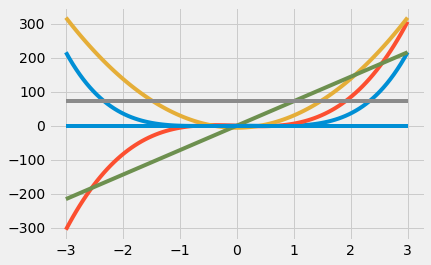

In [70]:
x= np.linspace(-3,3,100)

coef=[0,0,-3,0,3]
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))



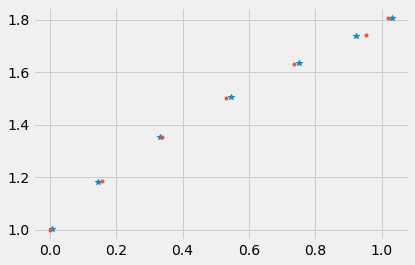

In [11]:
waypoints = p_trajs[:,1,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*')
plt.plot(waypoints[:,0],waypoints[:,1],'.')


# Allowing more time steps and smaller epsilon

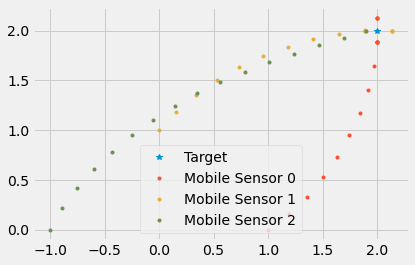

In [12]:
max_linear_speed=1.22
dt=0.2
epsilon=0.1
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([2,2])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])

n_p=3
n_timesteps=50

f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,3)

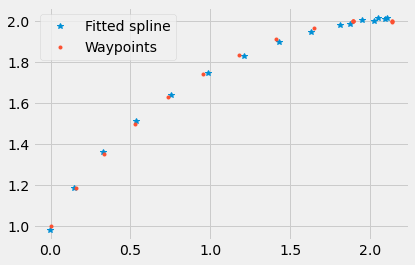

In [13]:
waypoints = p_trajs[:,1,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

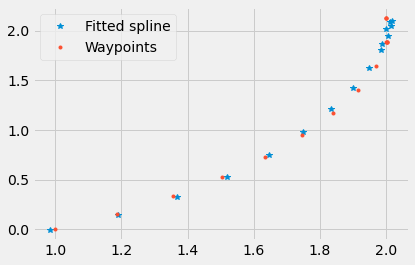

In [14]:
waypoints = p_trajs[:,0,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

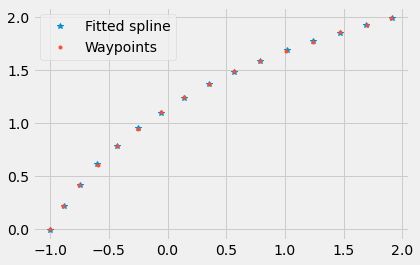

In [15]:
waypoints = p_trajs[:,2,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

# Plan very far ahead, using the imported version of the function

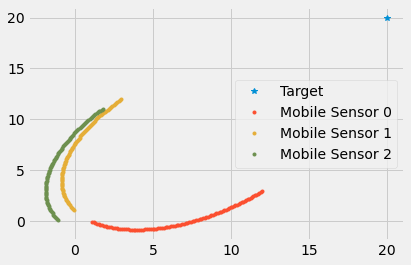

In [16]:
from FIMPathPlanning import FIM_ascent_path_planning
from dLdp import analytic_dLdp
from functools import partial
max_linear_speed=1.22
dt=0.1
epsilon=0.1
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([20,20])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])

n_p=3
n_timesteps=100

f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,3)

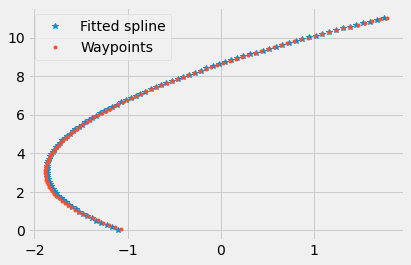

In [19]:
waypoints = p_trajs[:,2,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

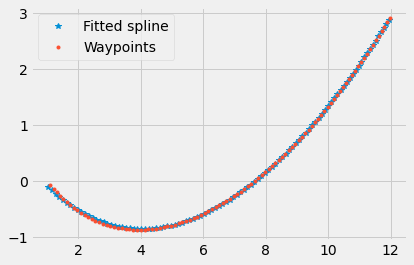

In [21]:
waypoints = p_trajs[:,0,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

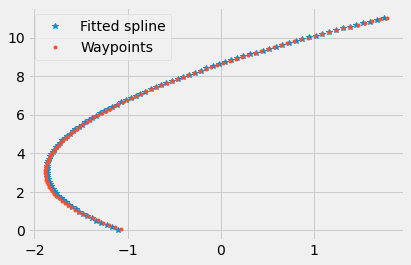

In [23]:
waypoints = p_trajs[:,2,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

# With n_timestep <=100, the path planing is very fast.